# Introduction to the Retina project – D7046E @ LTU.SE

This notebook serves as a starting point and playground for investigating what the 1D Retina project is about.
The idea is that you should familiarize yourself with both projects and later on decide which project to focus on (retina/SNN or chatbot/ANN).

In [ ]:
# Enable inline plots in the notebook
%matplotlib inline

# Import library functions needed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd


# Set default figure size
plt.rcParams['figure.figsize'] = [20,10]

# Function that is used to plot spike times
def rasterplot(ax, x, y, x_label, y_label):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x, y, marker='*')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Basic data generator

The following animation illustrates a simple motion detection task. A bright spot is moving across a one-dimensonal array of virtual receptor neurons.

![Concept illustration](https://drive.google.com/uc?export=view&id=1dc4TQ84ui5i9oVnGH9Au5sZfHKzt-2jd)

The task is to determine whether the pattern is moving and whether it is moving towards the left or right. The following code implements a basic spike data generator inspired by the animation above. For simplicity it is assumed that a bright spot is moving at constant speed back and forth, and that one spike is generated when the bright spot is passing over a receptor neuron.

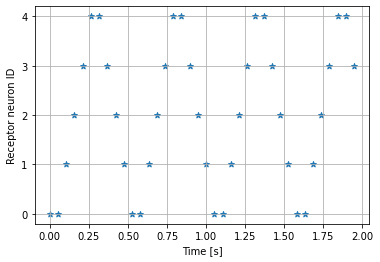

In [ ]:
####################################################################################################
# Simulation parameters
dt = 1e-4                    # Timestep
t = np.arange(0,20000)*dt    # Simulation time array t
num_receptors = 5           # Number of receptor neurons
speed = 20                   # Speed of bright spot, number of receptor neurons passed per second
####################################################################################################

plot_t = []                  # Time of spikes
plot_n = []                  # Receptor neuron id's
currtime = 0                 # Time when a spike is fired
neuronid = 0                 # Neuron that fires a spike
stepdir = 1                  # Is the bright spot moving towards the right (1) or left (-1)
timestep = 1.0/(speed-1)     # Time between spikes generated by nearby receptor neurons

# Make placeholders for spike time arrays to be used for SNN simulation
spikes = []
for i in range(num_receptors):
    spikes.append([])

# Generate and plot spikes from receptor neurons
extra_step = False;

while currtime < t[-1]:
    plot_t.append(currtime)
    plot_n.append(neuronid)
    spikes[neuronid].append(currtime)


    if neuronid == 0 and stepdir == -1:
        stepdir = 1
    elif neuronid == (num_receptors-1) and stepdir == 1:
        stepdir = -1

    # Extra step in bottom and top    
    if (neuronid == 4 or neuronid == 0):
        if extra_step: 
          neuronid += stepdir
          extra_step = False
        else: 
          extra_step = True
    else:
      neuronid += stepdir
    currtime += timestep
    
# Plot spikes
fig, ax = plt.subplots()
rasterplot(ax, plot_t, plot_n,'Time [s]','Receptor neuron ID')
ax.grid()

# Implement your first motion-detection SNN

There is a direction-selective network example in [Neuronify](https://ovilab.net/neuronify/), which is illustrated below. This network is designed so that the output neuron tends to fire a spike when the inputs are touched from right to left, but not when touched from left to right (with some limitations on the touching speed).

![First network implementation](https://drive.google.com/uc?export=view&id=1ZIyhUCtNebN1StlYCKEnC0qgXMZAF8d-)

Can you simulate this network using the code from SNN Exercise 1 and the input spikes provided by the data generator above? Can you modify the parameters of the simulated network so that it becomes direction selective?

If you succeed with this task then you have designed your first SNN vision system capable of basic motion detection!

**Note:** You need to complete SNN Exercise 1 to acquire the necessary background knowledge for this task.

In [ ]:
# def lif_cic_neuron(I_syn, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3):
#     # LIF neuron with a constant input current I_syn
#     return {
#         'type'    : 'lif_cic',
#         'u'       : u_reset,                   # Membrane potential [Volt]
#         'E_L'     : E_L,                       # Leakage resting potential [Volt]
#         'u_reset' : u_reset,                   # Reset potential after spike [Volt]
#         'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
#         'R'       : R,                         # Membrane resistance [Ohm]
#         'tau_m'   : tau_m,                     # Membrane time constant [second]
#         'I_syn'   : I_syn,                     # Postsynaptic current [Ampere]
#     }

# def lif_neuron(num_synapses, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3, tau_syn=50e-3):
#     # LIF neuron with current-based synapses (see lecture)
#     return {
#         'type'    : 'lif',
#         'u'       : u_reset,                   # Membrane potential [Volt]
#         'E_L'     : E_L,                       # Leakage resting potential [Volt]
#         'u_reset' : u_reset,                   # Reset potential after spike [Volt]
#         'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
#         'R'       : R,                         # Membrane resistance [Ohm]
#         'tau_m'   : tau_m,                     # Membrane time constant [second]
#         'tau_syn' : tau_syn,                   # Synapse time constant [second] (can also be an array)
#         'I_syn'   : np.zeros(num_synapses),    # Postsynaptic currents [Ampere]
#         'w_syn'   : np.zeros(num_synapses)     # Synaptic weights [Ampere]
#     }

def lif_neuron(I_inject, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3):
    # LIF neuron with a constant injection current
    return {
        'type'    : 'lif',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'E_L'     : E_L,                       # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'I_inj'   : I_inject,                  # Injection current [Ampere]
    }

def lif_syn_neuron(num_synapses, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=95e6, tau_m=30e-3, I_inject=0, tau_syn=50e-3):
    # LIF neuron with dynamic synapses
    n = lif_neuron(I_inject, E_L, u_reset, u_thres, R, tau_m)
    n['tau_syn'] = tau_syn                     # Synapse time constant [second] (can also be an array)
    n['I_syn']   = np.zeros(num_synapses)      # Postsynaptic currents [Ampere]
    n['w_syn']   = np.zeros(num_synapses)      # Synaptic weights [Ampere]
    n['type']    = 'lif_syn'
    return n

def lif_stdp_neuron(num_synapses, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=90e6, tau_m=30e-3, I_inject=0,
                    tau_syn=50e-3, tau_pls=20e-3, tau_mns=20e-3, w_max=1e-9, w_min=1e-12, gamma=1):
    # LIF neuron with dynamic synapses and pair-based STDP
    n = lif_syn_neuron(num_synapses, E_L, u_reset, u_thres, R, tau_m, I_inject, tau_syn)
    n['x_pre']   = np.zeros(num_synapses)      # STDP trace of presynaptic spikes
    n['y_pst']   = 0                           # STDP trace of postsynaptic spikes (scalar, one neuron)
    n['tau_pls'] = tau_pls                     # STDP trace time constant [second] (can also be an array)
    n['tau_mns'] = tau_mns                     # STDP trace time constant [second] (can also be an array)
    n['w_max']   = w_max                       # Largest allowed value of synapse conductance
    n['w_min']   = w_min                       # Lowest allowed value of synapse conductance
    n['gamma']   = gamma                       # Learning rate parameter with soft bounds (w_min,w_max)
    n['type']    = 'lif_stdp'
    return n

def integrate(dt, t, neurons):
    # Integrate the membrane potential, postsynaptic currents etc one timestep dt
    for n in neurons:
        if n['type'] == 'lif':
            # Integrate membrane potential
            dudt = (n['E_L'] - n['u'] + n['R']*n['I_inj']) / n['tau_m']
            n['u'] += dt*dudt
        elif n['type'] in ['lif_syn','lif_stdp']:
            # Integrate array of postsynaptic currents, one current for each synapse
            didt = np.divide(-n['I_syn'], n['tau_syn'])
            n['I_syn'] += dt*didt
            # Integrate membrane potential
            dudt = (n['E_L'] - n['u'] + n['R']*(n['I_inj']+sum(n['I_syn']))) / n['tau_m']
            n['u'] += dt*dudt
            # Integrate local traces for pair-based plasticity
            if n['type'] == 'lif_stdp':
                n['x_pre'] -= dt*np.divide(n['x_pre'], n['tau_pls'])       # Eq 19.12
                n['y_pst'] -= dt*np.divide(n['y_pst'], n['tau_mns'])       # Eq 19.13

# To simulate the spikes from the receptor neurons you will need an additional neuron constructor defined as

def spike_generator(spike_times):
    # Generates spikes at time points defined by the sorted list 'spike_t'
    return {
        'type'      : 'generator',
        'spike_t'   : spike_times              # Array of spike times, separated by at least dt
}

# To incorporate this neuron type in the simulator you will need to update the spikegen(dt,t,neurons) function

def spikegen(dt, t, neurons):
    # This function implements the non-linear spike generation mechanism
    spikes = []
    for i,n in enumerate(neurons):
        if n['type'] in ['lif_cic','lif', 'lif_syn', 'lif_stdp']:
            if n['u'] > n['u_thres']:
                n['u'] = n['u_reset']
                spikes.append(i)
        elif n['type'] == 'generator':
            j = np.searchsorted(n['spike_t'], t, side='right')
            if j>0 and t-n['spike_t'][j-1]<dt:
                spikes.append(i)
    return spikes

def snn_update(dt, t, neurons, connections):
    # This function updates the state of a spiking neural network by calling the functions above
    spikes = spikegen(dt, t, neurons)
    for (post, syn, pre) in connections:
        for spike in spikes:
            if spike == pre:
                if neurons[post]['type'] == 'lif':
                    neurons[post]['I_syn'][syn] += neurons[post]['w_syn'][syn]
                else:
                    print('Error: Spike sent to neuron type without synapses')
    integrate(dt, t, neurons)
    return spikes

# With these modifications of the simulator code you should be able to simulate the receptor neurons using
# spike_generator neurons initialized with the spike time arrays produced by the data generator code above.
# The construction of neurons and configuration of synapses should be done in a similar way as in SNN Exercise 1.

def update(dt, t, neurons, connections):
    # Update the state of a spiking neural network.
    # Refer to Exercise 3 for a reminder about how to set up connections between neurons.
    integrate(dt, t, neurons)
    spikes = spikegen(dt, t, neurons)

    # Update weights and STDP trace for each postsynaptic spike
    for spike in spikes:
        n = neurons[spike]
        if n['type'] in ['lif_stdp']:
            n['y_pst'] += 1                                         # Eq 19.13
            for i,w in enumerate(n['w_syn']):
                if w > 0:                                           # Excitatory synapses
                    Aplus = n['gamma']*(n['w_max'] - n['w_syn'][i]) # Eq 19.4
                    n['w_syn'][i] += dt*Aplus*n['x_pre'][i]         # Eq 19.14
    
    # Update synapse currents, weights and STDP traces for each presynaptic spike
    for (post, syn, pre) in connections:
        for spike in spikes:
            if spike == pre:
                n = neurons[post]
                
                if n['type'] not in ['lif_syn', 'lif_stdp']:
                    print('Error: Spike sent to neuron type without synapses')
                
                # Update synapse currents
                if n['type'] in ['lif_syn','lif_stdp']:
                    n['I_syn'][syn] += n['w_syn'][syn]
                    
                # Update STDP trace and weight
                if n['type'] in ['lif_stdp']:
                    n['x_pre'][syn] += 1                                   # Eq 19.12
                    if n['w_syn'][syn] > 0:                                # Excitatory synapses
                        Aminus = n['gamma']*(n['w_min'] - n['w_syn'][syn]) # Eq 19.4
                        n['w_syn'][syn] += dt*Aminus*n['y_pst']            # Eq 19.14
    
    return spikes

In [ ]:
n0 = spike_generator(spikes[0]);
n1 = spike_generator(spikes[1]);
n2 = spike_generator(spikes[2]);
n3 = spike_generator(spikes[3]);
n4 = spike_generator(spikes[4]);

n5 = lif_syn_neuron(2);                  # LIF neuron with 11 dynamic synapses
n6 = lif_syn_neuron(2);                  # LIF neuron with 11 dynamic synapses
n7 = lif_syn_neuron(2);                  # LIF neuron with 11 dynamic synapses
n8 = lif_syn_neuron(2);                  # LIF neuron with 11 dynamic synapses
n9 = lif_syn_neuron(2); 
n10 = lif_syn_neuron(2); 
n11 = lif_syn_neuron(2); 
n12 = lif_syn_neuron(2); 

left = lif_syn_neuron(4);                # LIF neuron with 11 dynamic synapses
right = lif_syn_neuron(4);

neurons = [n0, n1, n2, n3, n4, n5, n6, n7, n8, n9, n10, n11, n12, left, right] # A population of eleven neurons

layer1 = [n0, n1, n2, n3, n4]
layer2 = [n5, n6, n7, n8, n9, n10, n11, n12]

spike_gen = spike_generator(spikes)

In [ ]:
connections = []
weight_e = 350e-12
weight_i = -350e-12


for i in range(len(layer2)):
  if i > (len(layer2) / 2) - 1:                                                 # Right direction
    connections.append([len(layer1) + i, 0, i-(len(layer2) // 2)])
    connections.append([len(layer1) + i, 1, i+1-(len(layer2) // 2)])
    neurons[len(layer1) +i]['w_syn'][0] = weight_i
    neurons[len(layer1) +i]['w_syn'][1] = weight_e   
  else:                                                                         # Left direction
    connections.append([len(layer1) + i, 0, i])
    connections.append([len(layer1) + i, 1, i+1])
    neurons[len(layer1) +i]['w_syn'][0] = weight_e
    neurons[len(layer1) +i]['w_syn'][1] = weight_i

for i in range(len(layer2)):                                                    # Right direction
  if i > (len(layer2) / 2) - 1:
    connections.append([len(neurons)-1, i-(len(layer2) // 2), len(layer1)+i])
    neurons[-1]['w_syn'][i-(len(layer2) // 2)] = weight_e
  else:                                                                         # Left direction
    connections.append([len(neurons)-2, i, len(layer1)+i])
    neurons[-2]['w_syn'][i] = weight_e






print(connections)
print(len(connections))

[[5, 0, 0], [5, 1, 1], [6, 0, 1], [6, 1, 2], [7, 0, 2], [7, 1, 3], [8, 0, 3], [8, 1, 4], [9, 0, 0], [9, 1, 1], [10, 0, 1], [10, 1, 2], [11, 0, 2], [11, 1, 3], [12, 0, 3], [12, 1, 4], [13, 0, 5], [13, 1, 6], [13, 2, 7], [13, 3, 8], [14, 0, 9], [14, 1, 10], [14, 2, 11], [14, 3, 12]]
24


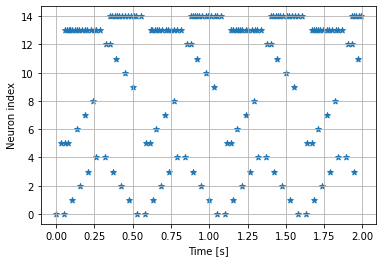

In [ ]:
dt = 1e-4

time = 0  
t1 = 2
tv = []
u1 = []
u2 = []
t_spike = []
n_spike = []

while time < t1:

    # Update the network
    spikes_res = update(dt, time, neurons, connections)
    
    # Store membrane potentials of n1 and n2 for plotting/analysis
    #tv.append(t)
    #u1.append(n1['u'])
    #u2.append(n2['u'])
    
    # Store spikes needed for plotting/analysis
    if len(spikes_res)>0:
        for s in spikes_res:
            t_spike.append(time)
            n_spike.append(s)

    # Timestep completed
    time += dt
    
fig, ax = plt.subplots()
rasterplot(ax, t_spike, n_spike,'Time [s]','Neuron index')
ax.grid()

# Further project work 

The challenge for the **1D Retina project** is to develop a more advanced vision system for (1D) motion classification, which is not limited to one specific pattern like the bright spot in the basic data generator above.

For example, you could consider using an open image dataset for training, validation and testing. For testing, the output of a webcam could optionally be considered. The delta modulator concept introduced in SNN Exercise 1 could potentially be used to convert pixel intensities to spikes. Optionally, you can use a [DAVIS346 neuromorphic vision sensor](https://inivation.github.io/inivation-docs/Hardware%20user%20guides/User_guide_-_DAVIS346.html) to record your own dataset.

Some inspiration for the SNN network architecture and training protocol can be obtained also from SNN Exercise 2. The [Reichardt Detector](https://en.wikipedia.org/wiki/Motion_perception#The_Reichardt-Hassenstein_model) is one starting point. For further inspiration, consider for example [motion detection in insects](https://link.springer.com/content/pdf/10.1007/s00359-019-01375-9.pdf).

In addition to considering differnt types of receptor models and SNN architectures for efficient and reliable motion classification, you can consider using other SNN simulators like [Brian2](https://brian2.readthedocs.io). Optionally you can consider using accelerators like [Brian2GeNN](https://brian2genn.readthedocs.io/en/stable/introduction/).

The possibilities for exploration are endless! How does the human retina work?

In [ ]:
# Useful links

# https://stackoverflow.com/questions/21546739/load-data-from-txt-with-pandas
# http://rpg.ifi.uzh.ch/davis_data.html#Zhu17cvpr

In [ ]:
# ORIGINAL 4 directions

# HEIGTH = 5
# WIDTH = 5
# DIRECTIONS = 4
# WEIGHT_EX = 350e-12
# WEIGHT_OUT_EX = 350e-12
# WEIGHT_OUT_IN = -350e-12
# WEIGHT_IN = -350e-12


# neurons = []
# connections = []

# # Input neurons
# for i in range(HEIGTH * WIDTH):
#     n_i = spike_generator(spikes[i])
#     neurons.append(n_i)

# LEFT to RIGHT
# start_index = len(neurons)
# for row in range(HEIGTH):
#     for col in range(WIDTH - 1): 
#         pre_index_ex = row * WIDTH + col
#         pre_index_in = row * WIDTH + col + 1
#         post_index = start_index + row * (WIDTH - 1) + col
#         connections.append([post_index, 0, pre_index_ex])
#         connections.append([post_index, 1, pre_index_in])
#         neurons.append(lif_neuron(2))
#         neurons[-1]['w_syn'][0] = WEIGHT_EX
#         neurons[-1]['w_syn'][1] = WEIGHT_IN
# neurons.append(lif_neuron(HEIGTH * (WIDTH - 1)))
# for pre_index in range(start_index, len(neurons) - 1):
#     post_index = len(neurons) - 1
#     synapse = pre_index - start_index
#     connections.append([post_index, synapse, pre_index])
#     neurons[-1]['w_syn'][synapse] = WEIGHT_OUT_EX

# RIGHT to LEFT
# start_index = len(neurons)
# for row in range(HEIGTH):
#     for col in range(WIDTH - 1): 
#         pre_index_ex = row * WIDTH + col
#         pre_index_in = row * WIDTH + col + 1
#         post_index = start_index + row * (WIDTH - 1) + col
#         connections.append([post_index, 0, pre_index_ex])
#         connections.append([post_index, 1, pre_index_in])
#         neurons.append(lif_neuron(2))
#         neurons[-1]['w_syn'][0] = WEIGHT_IN
#         neurons[-1]['w_syn'][1] = WEIGHT_EX
# neurons.append(lif_neuron(HEIGTH * (WIDTH - 1)))
# for pre_index in range(start_index, len(neurons) - 1):
#     post_index = len(neurons) - 1
#     synapse = pre_index - start_index
#     connections.append([post_index, synapse, pre_index])
#     neurons[-1]['w_syn'][synapse] = WEIGHT_OUT_EX

# # UP to DOWN
# start_index = len(neurons)
# for col in range(WIDTH):
#     for row in range(HEIGTH - 1): 
#         pre_index_ex = row * WIDTH + col
#         pre_index_in = row * WIDTH + col + WIDTH
#         post_index = start_index + row * WIDTH + col
#         connections.append([post_index, 0, pre_index_ex])
#         connections.append([post_index, 1, pre_index_in])
#         neurons.append(lif_neuron(2))
#         neurons[-1]['w_syn'][0] = WEIGHT_EX
#         neurons[-1]['w_syn'][1] = WEIGHT_IN
# neurons.append(lif_neuron(WIDTH * (HEIGTH - 1)))
# for pre_index in range(start_index, len(neurons) - 1):
#     post_index = len(neurons) - 1
#     synapse = pre_index - start_index
#     connections.append([post_index, synapse, pre_index])
#     neurons[-1]['w_syn'][synapse] = WEIGHT_OUT_EX

# # DOWN to UP
# start_index = len(neurons)
# for col in range(WIDTH):
#     for row in range(HEIGTH - 1): 
#         pre_index_ex = row * WIDTH + col
#         pre_index_in = row * WIDTH + col + WIDTH
#         post_index = start_index + row * WIDTH + col
#         connections.append([post_index, 0, pre_index_ex])
#         connections.append([post_index, 1, pre_index_in])
#         neurons.append(lif_neuron(2))
#         neurons[-1]['w_syn'][0] = WEIGHT_IN
#         neurons[-1]['w_syn'][1] = WEIGHT_EX
# neurons.append(lif_neuron(WIDTH * (HEIGTH - 1)))
# for pre_index in range(start_index, len(neurons) - 1):
#     post_index = len(neurons) - 1
#     synapse = pre_index - start_index
#     connections.append([post_index, synapse, pre_index])
#     neurons[-1]['w_syn'][synapse] = WEIGHT_OUT_EX

In [ ]:
# # UP to DOWN
# start_index = len(neurons)
# for col in range(WIDTH):
#     for row in range(HEIGTH - 1): 
#         pre_index_ex = row * WIDTH + col
#         pre_index_in = pre_index_ex + WIDTH
#         post_index = start_index + row * (WIDTH - 1) + col
#         connections.append([post_index, 0, pre_index_ex])
#         connections.append([post_index, 1, pre_index_in])
#         neurons.append(lif_neuron(2))
#         neurons[-1]['w_syn'][0] = WEIGHT_EX
#         neurons[-1]['w_syn'][1] = WEIGHT_IN

# hidden_index = len(neurons)
# for col in range(WIDTH):
#     for row in range(HEIGTH - 2):
#         pre_index_1 = start_index + row * (WIDTH - 1) + col
#         pre_index_2 = pre_index_1 + WIDTH
#         post_index = hidden_index + row * (WIDTH - 2) + col
#         connections.append([post_index, 0, pre_index_1])
#         connections.append([post_index, 1, pre_index_2])
#         neurons.append(lif_neuron(2))
#         neurons[-1]['w_syn'][0] = WEIGHT_EX / 2
#         neurons[-1]['w_syn'][1] = WEIGHT_EX / 2


# neurons.append(lif_neuron(WIDTH * (HEIGTH - 2)))
# for pre_index in range(hidden_index, len(neurons) - 1):
#     post_index = len(neurons) - 1
#     synapse = pre_index - hidden_index
#     connections.append([post_index, synapse, pre_index])
#     neurons[-1]['w_syn'][synapse] = WEIGHT_OUT_EX

# # DOWN TO UP 
# start_index = len(neurons)
# for col in range(WIDTH):
#     for row in range(HEIGTH - 1): 
#         pre_index_ex = row * WIDTH + col
#         pre_index_in = pre_index_ex + WIDTH
#         post_index = start_index + row * (WIDTH - 1) + col
#         connections.append([post_index, 0, pre_index_ex])
#         connections.append([post_index, 1, pre_index_in])
#         neurons.append(lif_neuron(2))
#         neurons[-1]['w_syn'][0] = WEIGHT_IN
#         neurons[-1]['w_syn'][1] = WEIGHT_EX

# hidden_index = len(neurons)
# for col in range(WIDTH):
#     for row in range(HEIGTH - 2):
#         pre_index_1 = start_index + row * (WIDTH - 1) + col
#         pre_index_2 = pre_index_1 + WIDTH
#         post_index = hidden_index + row * (WIDTH - 2) + col
#         connections.append([post_index, 0, pre_index_1])
#         connections.append([post_index, 1, pre_index_2])
#         neurons.append(lif_neuron(2))
#         neurons[-1]['w_syn'][0] = WEIGHT_EX / 2
#         neurons[-1]['w_syn'][1] = WEIGHT_EX / 2


# neurons.append(lif_neuron(WIDTH * (HEIGTH - 2)))
# for pre_index in range(hidden_index, len(neurons) - 1):
#     post_index = len(neurons) - 1
#     synapse = pre_index - hidden_index
#     connections.append([post_index, synapse, pre_index])
#     neurons[-1]['w_syn'][synapse] = WEIGHT_OUT_EX

In [ ]:
# # NEW WITH 2 HIDDEN LAYERS

# def createConnections(spikes, HEIGHT, WIDTH, DIRECTIONS=4, WEIGHT_EX=350e-12, WEIGHT_OUT_EX=350e-12, WEIGHT_IN = -350e-12):
#   neurons = []
#   connections = []
#   layer_index = []

#   # Input neurons
#   for i in range(HEIGHT * WIDTH):
#       n_i = spike_generator(spikes[i])
#       neurons.append(n_i)

#   # LEFT to RIGHT
#   right_left = []
#   start_index = len(neurons)
#   for row in range(HEIGHT):
#       for col in range(WIDTH - 1): 
#           pre_index_ex = row * WIDTH + col
#           pre_index_in = pre_index_ex + 1
#           post_index = start_index + row * (WIDTH - 1) + col
#           connections.append([post_index, 0, pre_index_ex])
#           connections.append([post_index, 1, pre_index_in])
#           neurons.append(lif_syn_neuron(2))
#           neurons[-1]['w_syn'][0] = WEIGHT_EX
#           neurons[-1]['w_syn'][1] = WEIGHT_IN 

#   right_left.append([start_index, len(neurons) - 1])

#   hidden_index = len(neurons)
#   for row in range(HEIGHT):
#       for col in range(WIDTH - 2):
#           # pre_index_1 = start_index + row * (WIDTH - 1) + col
#           # pre_index_2 = pre_index_1 + 1
#           # post_index = hidden_index + row * (WIDTH - 2) + col
#           # connections.append([post_index, 0, pre_index_1])
#           # connections.append([post_index, 1, pre_index_2])
#           # neurons.append(lif_stdp_neuron(num_synapses=2, w_min=WEIGHT_EX / 2, w_max=WEIGHT_EX * 2))
#           # neurons[-1]['w_syn'][0] = WEIGHT_EX / 2
#           # neurons[-1]['w_syn'][1] = WEIGHT_EX / 2

#           pre_index_1 = start_index + row * (WIDTH - 1) + col
#           post_index = hidden_index + row * (WIDTH - 2) + col

#           connections.append([post_index, 0, pre_index_1])
#           for r in range(HEIGHT): 
#               pre_index_2 = start_index + r * (WIDTH - 1) + col + 1
#               connections.append([post_index, r+1, pre_index_2])
#           neurons.append(lif_stdp_neuron(num_synapses=HEIGHT+1, w_min=WEIGHT_EX / 2, w_max=WEIGHT_EX * 2))
#           for synapse in range(HEIGHT+1):
#               neurons[-1]['w_syn'][synapse] = WEIGHT_EX 

#   right_left.append([hidden_index, len(neurons) - 1])
#   right_left.append(len(neurons))

#   print("LEFT TO RIGHT INDEX: ", len(neurons))
#   neurons.append(lif_syn_neuron(HEIGHT * (WIDTH - 2)))
#   for pre_index in range(hidden_index, len(neurons) - 1):
#       post_index = len(neurons) - 1
#       synapse = pre_index - hidden_index
#       connections.append([post_index, synapse, pre_index])
#       neurons[-1]['w_syn'][synapse] = WEIGHT_OUT_EX

#   layer_index.append(right_left)

#   # RIGHT to LEFT
#   left_right = []
#   start_index = len(neurons)
#   for row in range(HEIGHT):
#       for col in range(WIDTH - 1): 
#           pre_index_in = row * WIDTH + col
#           pre_index_ex = pre_index_in + 1
#           post_index = start_index + row * (WIDTH - 1) + col
#           connections.append([post_index, 0, pre_index_ex])
#           connections.append([post_index, 1, pre_index_in])
#           neurons.append(lif_syn_neuron(2))
#           neurons[-1]['w_syn'][0] = WEIGHT_EX
#           neurons[-1]['w_syn'][1] = WEIGHT_IN 

#   left_right.append([start_index, len(neurons) - 1])

#   hidden_index = len(neurons)
#   for row in range(HEIGHT):
#       for col in range(WIDTH - 2):
#           # pre_index_1 = start_index + row * (WIDTH - 1) + col
#           # pre_index_2 = pre_index_1 + 1
#           # post_index = hidden_index + row * (WIDTH - 2) + col
#           # connections.append([post_index, 0, pre_index_1])
#           # connections.append([post_index, 1, pre_index_2])
#           # neurons.append(lif_stdp_neuron(num_synapses=2, w_min=WEIGHT_EX / 2, w_max=WEIGHT_EX * 2))
#           # neurons[-1]['w_syn'][0] = WEIGHT_EX / 2
#           # neurons[-1]['w_syn'][1] = WEIGHT_EX / 2

#           pre_index_1 = start_index + row * (WIDTH - 1) + col
#           post_index = hidden_index + row * (WIDTH - 2) + col

#           connections.append([post_index, 0, pre_index_1])
#           for r in range(HEIGHT): 
#               pre_index_2 = start_index + r * (WIDTH - 1) + col + 1
#               connections.append([post_index, r+1, pre_index_2])
#           neurons.append(lif_stdp_neuron(num_synapses=HEIGHT+1, w_min=WEIGHT_EX / 2, w_max=WEIGHT_EX * 2))
#           for synapse in range(HEIGHT+1):
#               neurons[-1]['w_syn'][synapse] = WEIGHT_EX 

#   left_right.append([hidden_index, len(neurons) - 1])
#   left_right.append(len(neurons))

#   print("RIGHT TO LEFT INDEX: ", len(neurons))
#   neurons.append(lif_syn_neuron(HEIGHT * (WIDTH - 2)))
#   for pre_index in range(hidden_index, len(neurons) - 1):
#       post_index = len(neurons) - 1
#       synapse = pre_index - hidden_index
#       connections.append([post_index, synapse, pre_index])
#       neurons[-1]['w_syn'][synapse] = WEIGHT_OUT_EX

#   layer_index.append(left_right)

#   print(connections[0:40])
#   print(connections[40:70])
#   print(connections[70:85])
#   return neurons, connections, layer_index

In [ ]:
# Import data

# decoder = aedat.Decoder('dvSave-2021_12_09_13_50_32.aedat4')
# print(decoder.id_to_stream())

# for packet in decoder:
#     print(packet['stream_id'], end=': ')
#     if 'events' in packet:
#         print('{} polarity events'.format(len(packet['events'])))
#     elif 'frame' in packet:
#         print('{} x {} frame'.format(packet['frame']['width'], packet['frame']['height']))
#     elif 'imus' in packet:
#         print('{} IMU samples'.format(len(packet['imus'])))
#     elif 'triggers' in packet:
#         print('{} trigger events'.format(len(packet['triggers'])))

In [ ]:
!pip install aedat
import aedat as aedat

     |████████████████████████████████| 395 kB 4.3 MB/s 


In [ ]:
def manualSpikeGen():
    spikes = []
    for i in range(5**2):
        spikes.append([])

    timestep = 5e-2
    time = 0
    for row in range(5):
        # R - L
        for i in range(4, 0, -1):
            spikes[5*row + i].append(time)
            spikes[5*((row + 1) % 4) + i].append(time)
            time += timestep
        # L - R
        for i in range(5):
            spikes[5*row + i].append(time)
            time += timestep

        # Testing out with zig-zag pattern
        # for i in range(4, 2, -1):
        #   spikes[5*row + i].append(time)
        #   time += timestep
        # for i in range(3, 5):
        #   spikes[5*row + i].append(time)
        #   time += timestep      
        # for i in range(3, 1, -1):
        #   spikes[5*row + i].append(time)
        #   time += timestep    
        # for i in range(1, 5):
        #   spikes[5*row + i].append(time)
        #   time += timestep    

    # Top left - Down right
    # L - R DIAG
    for i in range(5):
        spikes[i*5 + i].append(time)
        spikes[(4-i)*5 + (4-i)].append(time)
        time += timestep
    # R - L DIAG
    for i in range(3, -1, -1):
        spikes[i*5 + i].append(time)
        time += timestep

    # Down left - top right
    # L - R DIAG
    for i in range(5):
      spikes[(4-i)*5 + i].append(time)
      time += timestep
    # R - L DIAG
    for i in range(3, -1, -1):
      spikes[(4-i)*5 + i].append(time)
      time += timestep


    return spikes

In [ ]:
def createConnections(spikes, height, width, direction=2, weight_ex=350e-12, weight_in= -350e-12):
    neurons = []
    connections = []
    layer_index = []
    for d in range(direction):
        layer_index.append([])

    def input():
        for i in range(height * width):
            n_i = spike_generator(spikes[i])
            neurons.append(n_i)
    
    def hidden(dir):
        start_index = len(neurons)
        for row in range(height):
            for col in range(width - 1): 
                pre_index_ex = []
                pre_index_in = []
                if dir == 0: 
                    # L - R
                    for r in range(height):
                        pre_index_ex.append(r * width + col + 1)
                        pre_index_in.append(r * width + col)
                else:
                    # R - L 
                    for r in range(height):
                        pre_index_ex.append(r * width + col)
                        pre_index_in.append(r * width + col + 1)

                post_index = start_index + row * (width - 1) + col
                
                neurons.append(lif_syn_neuron(len(pre_index_ex) + len(pre_index_in)))

                for ex_synapse, pre_index in enumerate(pre_index_ex):
                    connections.append([post_index, ex_synapse, pre_index])
                    neurons[-1]['w_syn'][ex_synapse] = weight_ex
                for in_synapse, pre_index in enumerate(pre_index_in):
                    connections.append([post_index, len(pre_index_ex) + in_synapse, pre_index])
                    neurons[-1]['w_syn'][len(pre_index_ex) + in_synapse] = weight_in

        layer_index[dir].append([start_index, len(neurons) - 1])
        print([start_index, len(neurons) - 1])

    def output():   
        for dir in range(direction):
            neurons.append(lif_syn_neuron(height * (width - 1)))
            pre_indexes = layer_index[dir][0]
            for pre_index in range(pre_indexes[0], pre_indexes[1] + 1):
                post_index = len(neurons) - 1
                synapse = pre_index - pre_indexes[0]
                connections.append([post_index, synapse, pre_index])
                neurons[-1]['w_syn'][synapse] = weight_ex
            layer_index[dir].append(len(neurons) - 1)

    input()
    hidden(0)
    hidden(1)
    output()


    # print("HIDDEN:")
    # conHidden =height * (width-1) * 2 * height
    # print(connections[0:(conHidden)])
    # print(connections[conHidden:(conHidden*2)])

    # print("OUTPUT:")
    # print(connections[(2*conHidden):])

    return neurons, connections, layer_index

In [ ]:
def train(neurons, connections):  

    dt = 1e-4
  
    t1 = 5
    tv = []
    u1 = []
    u2 = []
    t_spike = []
    n_spike = []
    
    for iteration in range(1):

        time = 0

        while time < t1:

            # Update the network
            spikes_res = update(dt, time, neurons, connections)
            
            
            # Store spikes needed for plotting/analysis
            if len(spikes_res)>0:
                for s in spikes_res:
                    t_spike.append(time)
                    n_spike.append(s)

            # Timestep completed
            time += dt
    return t_spike, n_spike

In [ ]:
def append_plot(ax, x, y_values, layer_index=[], color='#1f77b4'):
    for i, y in enumerate(y_values): 
        if len(layer_index) > 2 and (y == layer_index[-1]):
            ax.scatter(x[i], y, marker='o', c=color)
        # elif len(layer_index) > 1 and (y >= layer_index[1][0] and y <= layer_index[1][1]):
        #     ax.scatter(x[i], y, marker='*', c=color)
        else:
            ax.scatter(x[i], y, marker='.', c=color)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
def plotSpikes(n_spike, t_spike, layer_index, height, width):
  input = [[], []]
  lr =  [[], []]
  rl = [[], []]
  print(layer_index)
  for i, neuron_index in enumerate(n_spike):
    if (neuron_index < height * width): 
        input[0].append(neuron_index)
        input[1].append(t_spike[i])
    elif (neuron_index <= layer_index[0][0][-1]) or (neuron_index == layer_index[0][-1]):
        lr[0].append(neuron_index)
        lr[1].append(t_spike[i])
    elif (neuron_index <= layer_index[1][0][-1]) or (neuron_index == layer_index[1][-1]):
        rl[0].append(neuron_index)
        rl[1].append(t_spike[i])
    
  fig, ax = plt.subplots()
  append_plot(ax, input[1], input[0])
  append_plot(ax, lr[1], lr[0], layer_index[0], "Green")
  append_plot(ax, rl[1], rl[0], layer_index[1], "Red")
  ax.grid()

[25, 44]
[45, 64]
Neurons spikes:  [4, 9, 28, 32, 36, 40, 44, 65, 65, 65, 28, 32, 36, 40, 44, 65, 65, 65, 65, 65, 65, 65, 65, 28, 32, 36, 40, 44, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 3, 8, 65, 65, 65, 65, 65, 27, 31, 35, 39, 43, 65, 65, 65, 65, 65, 65, 65, 65, 27, 31, 35, 39, 43, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 27, 31, 35, 39, 43, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 2, 7, 65, 65, 65, 65, 65, 65, 65, 26, 30, 34, 38, 42, 65, 65, 65, 65, 65, 65, 65, 65, 65, 26, 30, 34, 38, 42, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 26, 30, 34, 38, 42, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 1, 6, 65, 65, 65, 65, 65, 65, 65, 25, 29, 33, 37, 41, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 25, 29, 33, 37, 41, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 25, 29, 33, 37, 41, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 0, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 6

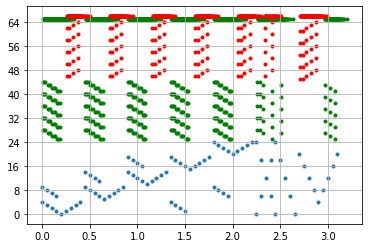

In [ ]:
HEIGHT = 5
WIDTH = 5

spikes = manualSpikeGen()
neurons, connections, layer_index = createConnections(spikes, HEIGHT, WIDTH)
t_spike, n_spike = train(neurons, connections)
print("Neurons spikes: ", n_spike)
plotSpikes(n_spike, t_spike, layer_index, HEIGHT, WIDTH)

[[[25, 44], 65], [[45, 64], 66]]


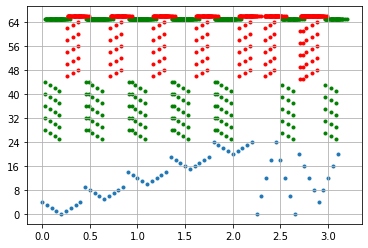

In [ ]:
plotSpikes(n_spike, t_spike, layer_index, HEIGHT, WIDTH)